In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 5
particles = 10
early_stopping = 0.001
batch_normal = False # noch einbauen, aber Achtung mit den Dimensionen unten!!!
shuffle = True
randomization = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 2.3805 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================] - 0s 2ms/step - loss: 2.4470 - accuracy: 0.0700
0.07000000029802322
16/16 [==============================] - 0s 2ms/step - loss: 2.3891 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 2ms/step - loss: 2.4278 - accuracy: 0.1240
0.12399999797344208
16/16 [==============================] - 0s 2ms/step - loss: 2.4027 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 2ms/step - loss: 2.4314 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 2ms/step - loss: 2.3707 - accuracy: 0.0920
0.09200000017881393
16/16 [==============================] - 0s 2ms/step - loss: 2.5079 - accuracy: 0.0680
0.06800000369548798
16/16 [==============================] - 0s 2ms/step - loss: 2.4219 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================]

In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 268.3126859664917


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 2.3061 - accuracy: 0.1100
0.10999999940395355
16/16 [==============================] - 0s 2ms/step - loss: 3.4247 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 2ms/step - loss: 26.1204 - accuracy: 0.1080
0.1080000028014183
16/16 [==============================] - 0s 2ms/step - loss: 6.2772 - accuracy: 0.1080
0.1080000028014183
16/16 [==============================] - 0s 3ms/step - loss: 4.1839 - accuracy: 0.1000
0.10000000149011612
16/16 [==============================] - 0s 1ms/step - loss: 2.3168 - accuracy: 0.1340
0.1340000033378601
16/16 [==============================] - 0s 2ms/step - loss: 7.9762 - accuracy: 0.0800
0.07999999821186066
16/16 [==============================] - 0s 2ms/step - loss: 1549.2111 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 2ms/step - loss: 2.3407 - accuracy: 0.1060
0.10599999874830246
16/16 [=============================

In [18]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa8b18048>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa8b43988>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa8b77b08>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa8ba8e88>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa8bdc088>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa9bd8388>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa9c0a6c8>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa9c399c8>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa9c6cdc8>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x28aa9c692c8>}

In [19]:
model_dict["model_1"].get_weights()

[array([[ 6.88005798e-03,  1.45396609e-02,  1.16096362e-02, ...,
          2.93100029e-02, -1.53116770e-02, -6.18133054e-04],
        [ 1.62922535e-02,  1.16706835e-02,  5.53687336e-03, ...,
         -3.15514691e-02, -1.43177081e-02, -1.79036576e-02],
        [-3.98265012e-03, -3.68317682e-03,  1.50137702e-02, ...,
         -1.00583220e-02, -5.25286049e-03,  3.19083850e-03],
        ...,
        [-5.30651957e-03, -1.35923771e-03,  4.97273682e-03, ...,
         -1.30281895e-02,  2.66700666e-02,  8.78137071e-03],
        [-6.03714585e-03,  9.43052396e-03, -9.96893644e-03, ...,
          8.40073917e-03, -5.95601814e-05,  1.32814245e-02],
        [-1.54643385e-02,  1.53593216e-02,  1.12743238e-02, ...,
          1.52068604e-02,  2.23414563e-02, -1.02708815e-02]], dtype=float32),
 array([ 1.22187808e-02, -1.34564405e-02, -1.70308668e-02, -1.08636105e-02,
         1.39596798e-02,  2.67555416e-02, -1.05883693e-02,  1.73656773e-02,
         8.15622229e-03,  2.39617024e-02,  2.37795096e-02, -2.

In [20]:
y_pred_dict["model_1"]

array([[0.09208901, 0.09279133, 0.10275147, 0.09749366, 0.11620315,
        0.09825902, 0.1009064 , 0.10036968, 0.10672387, 0.09241243],
       [0.09202866, 0.09269521, 0.10291163, 0.09736408, 0.11614186,
        0.09834695, 0.10094772, 0.1003514 , 0.10649164, 0.0927209 ],
       [0.09208053, 0.09271823, 0.10275638, 0.09739409, 0.11613129,
        0.09843706, 0.10098471, 0.10039522, 0.10639628, 0.09270629],
       [0.09195007, 0.09268139, 0.10278122, 0.09732074, 0.11616001,
        0.09843893, 0.10106835, 0.10028873, 0.10642069, 0.09288988],
       [0.09210806, 0.0926553 , 0.10270735, 0.09741075, 0.11619737,
        0.09834231, 0.10096381, 0.10028207, 0.10661609, 0.09271683],
       [0.0919752 , 0.09278537, 0.10292472, 0.0973727 , 0.11610345,
        0.098189  , 0.10104485, 0.10035254, 0.10660258, 0.09264954],
       [0.09209573, 0.09272912, 0.10291085, 0.09742685, 0.11608182,
        0.09822617, 0.10097957, 0.10039276, 0.10656665, 0.09259044],
       [0.09206968, 0.09253161, 0.1026666

In [21]:
jacobian_dict["model_1"]

array([[ -0.       ,  -0.       ,  -9.280616 ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       , -10.233226 ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -9.667715 ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -8.253548 ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -8.959282 ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -9.49194  ,  -0.       ,  -0.       ],
       [ -0.       , -10.232365 ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       

In [22]:
train_acc_dict

{'model_1': [0.11500000208616257,
  0.0729999989271164,
  0.09099999815225601,
  0.0860000029206276,
  0.11299999803304672,
  0.12099999934434891,
  0.12200000137090683,
  0.09000000357627869,
  0.1120000034570694,
  0.09799999743700027,
  0.13199999928474426,
  0.12099999934434891,
  0.09200000017881393,
  0.0949999988079071,
  0.09399999678134918,
  0.09600000083446503,
  0.09399999678134918,
  0.07199999690055847,
  0.08100000023841858,
  0.06700000166893005,
  0.07800000160932541,
  0.09099999815225601,
  0.08799999952316284,
  0.09200000017881393,
  0.09700000286102295,
  0.10599999874830246,
  0.09300000220537186,
  0.09200000017881393,
  0.06499999761581421,
  0.07400000095367432,
  0.09600000083446503,
  0.09799999743700027,
  0.11299999803304672,
  0.09000000357627869,
  0.11299999803304672,
  0.1080000028014183,
  0.0989999994635582,
  0.0729999989271164,
  0.09200000017881393,
  0.09200000017881393,
  0.10100000351667404,
  0.10300000011920929,
  0.10400000214576721,
  0.097

In [23]:
test_acc_dict

{'model_1': [0.11400000005960464,
  0.0860000029206276,
  0.07599999755620956,
  0.0860000029206276,
  0.10000000149011612,
  0.11599999666213989,
  0.11800000071525574,
  0.1120000034570694,
  0.12800000607967377,
  0.09399999678134918,
  0.10999999940395355,
  0.07400000095367432,
  0.06599999964237213,
  0.07800000160932541,
  0.0820000022649765,
  0.052000001072883606,
  0.12399999797344208,
  0.08799999952316284,
  0.0860000029206276,
  0.07199999690055847,
  0.07999999821186066,
  0.0820000022649765,
  0.07999999821186066,
  0.07400000095367432,
  0.052000001072883606,
  0.08799999952316284,
  0.05999999865889549,
  0.07400000095367432,
  0.05400000140070915,
  0.07800000160932541,
  0.10599999874830246,
  0.08399999886751175,
  0.10199999809265137,
  0.10199999809265137,
  0.13199999928474426,
  0.1120000034570694,
  0.10999999940395355,
  0.10199999809265137,
  0.09399999678134918,
  0.09000000357627869,
  0.1120000034570694,
  0.1120000034570694,
  0.1120000034570694,
  0.1159

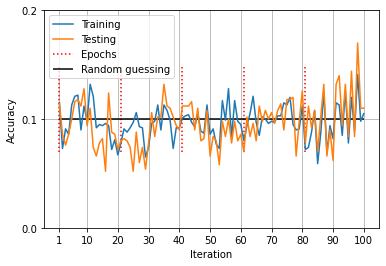

In [24]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

Hier jetzt das Modell mit den gemittelten Gewichten und Bias aus allen Partikel-Modellen.

In [25]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [26]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 2.3832 - accuracy: 0.1120


[2.383166551589966, 0.1120000034570694]

## Wir versuchen das gleiche mit der (falschen?) Jacobi-Matrix aus Tensorflow

In [27]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [28]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [29]:
import tensorflow as tf

loss_fct = tf.keras.losses.CategoricalCrossentropy(reduction = "none")

In [30]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            y_batch_tf = tf.constant(y_batches[b])
            y_pred_tf = tf.Variable(y_pred_dict["model_{}".format(str(i+1))])
            
            with tf.GradientTape() as tape:
                loss_value = loss_fct(y_batch_tf, y_pred_tf)
            jacobian_tf = tape.gradient(loss_value, y_pred_tf)
            
            jacobian_dict["model_{}".format(str(i+1))] = jacobian_tf.numpy()
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights

In [31]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 2.3317 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 2ms/step - loss: 172154.1250 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 2ms/step - loss: 2.3206 - accuracy: 0.0980
0.09799999743700027
16/16 [==============================] - 0s 2ms/step - loss: 2.3024 - accuracy: 0.1220
0.12200000137090683
16/16 [==============================] - 0s 2ms/step - loss: 69844.4531 - accuracy: 0.1100
0.10999999940395355
16/16 [==============================] - 0s 2ms/step - loss: 6936.4009 - accuracy: 0.1200
0.11999999731779099
16/16 [==============================] - 0s 2ms/step - loss: 2.3482 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3123 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 2ms/step - loss: 2.3069 - accuracy: 0.0840
0.08399999886751175
16/16 [==================

In [32]:
model_dict["model_1"].get_weights()

[array([[ 2.06954982e-02,  5.63060716e-02, -4.07686345e-02, ...,
          4.46999855e-02, -1.73134338e-02, -1.99938882e-02],
        [ 5.61660575e-03,  3.75522650e-05,  9.54252481e-03, ...,
         -1.47397602e-02, -1.07378652e-02, -9.11305565e-03],
        [ 1.64672416e-02,  4.01837081e-02,  8.39894358e-03, ...,
          3.64508107e-03,  2.70969030e-02,  2.90414947e-03],
        ...,
        [-3.80617455e-02, -1.23177012e-02,  5.21913096e-02, ...,
          1.29750511e-02,  4.25481908e-02, -2.45569255e-02],
        [ 3.30458917e-02, -3.49188559e-02,  6.74226088e-04, ...,
         -1.26963705e-02, -5.03315181e-02, -1.87207926e-02],
        [ 4.21037376e-02,  8.76032980e-04, -5.15797324e-02, ...,
          3.66022028e-02, -6.41405862e-03,  4.61283587e-02]], dtype=float32),
 array([ 0.00983678, -0.01307164, -0.01564935, -0.03652757,  0.03035844,
        -0.04892964, -0.02887733, -0.0044841 , -0.00475757,  0.02039193,
         0.0314684 ,  0.00919374,  0.03527285,  0.01242317,  0.02188

In [33]:
y_pred_dict["model_1"]

array([[0.08208754, 0.12064803, 0.1095037 , 0.11947201, 0.09890037,
        0.08784453, 0.09366183, 0.09858997, 0.14131951, 0.0479725 ],
       [0.09281829, 0.10534818, 0.10764629, 0.12824917, 0.09529268,
        0.0953891 , 0.08997142, 0.1026117 , 0.11967771, 0.06299534],
       [0.09306902, 0.11540582, 0.10456655, 0.12936634, 0.08950666,
        0.10697589, 0.09159423, 0.1000259 , 0.10647533, 0.06301419],
       [0.07902306, 0.12240607, 0.11137873, 0.1708617 , 0.08036304,
        0.10053031, 0.08737415, 0.08947188, 0.0974087 , 0.0611823 ],
       [0.08856017, 0.1142875 , 0.10465243, 0.15219924, 0.09229705,
        0.09511613, 0.087363  , 0.09612519, 0.10997805, 0.05942127],
       [0.09312359, 0.11346515, 0.10804393, 0.13931635, 0.08508661,
        0.10281011, 0.09201296, 0.09334823, 0.10539597, 0.06739714],
       [0.08472537, 0.11224005, 0.10958719, 0.13530536, 0.09706042,
        0.10923839, 0.0807519 , 0.10945812, 0.10628907, 0.05534409],
       [0.09125988, 0.11399299, 0.1089774

In [34]:
jacobian_dict["model_1"]

array([[  1.        ,   1.        ,   1.        ,   1.        ,
         -9.111186  ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ],
       [  1.0000002 ,   1.0000002 ,   1.0000002 ,   1.0000002 ,
         -9.493985  ,   1.0000002 ,   1.0000002 ,   1.0000002 ,
          1.0000002 ,   1.0000002 ],
       [  1.        ,  -7.6650743 ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ],
       [  1.        ,   1.        ,   1.        ,  -4.8526864 ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ],
       [  0.99999994,   0.99999994,   0.99999994,  -5.570335  ,
          0.99999994,   0.99999994,   0.99999994,   0.99999994,
          0.99999994,   0.99999994],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,  -9.868034  ,   1.        ,
          1.        ,   1.        ],
       [  

In [35]:
train_acc_dict

{'model_1': [0.07900000363588333,
  0.07999999821186066,
  0.05000000074505806,
  0.05700000002980232,
  0.07999999821186066,
  0.08799999952316284,
  0.10400000214576721,
  0.12700000405311584,
  0.125,
  0.09600000083446503,
  0.11400000005960464,
  0.09600000083446503,
  0.12099999934434891,
  0.1120000034570694,
  0.12300000339746475,
  0.11699999868869781,
  0.11999999731779099,
  0.12300000339746475,
  0.12300000339746475,
  0.12700000405311584,
  0.10300000011920929,
  0.0949999988079071,
  0.07000000029802322,
  0.12700000405311584,
  0.09200000017881393,
  0.09099999815225601,
  0.06499999761581421,
  0.09300000220537186,
  0.125,
  0.1340000033378601,
  0.12099999934434891,
  0.0820000022649765,
  0.09700000286102295,
  0.09600000083446503,
  0.0989999994635582,
  0.09799999743700027,
  0.0860000029206276,
  0.0989999994635582,
  0.0989999994635582,
  0.09600000083446503,
  0.11800000071525574,
  0.09000000357627869,
  0.11500000208616257,
  0.08699999749660492,
  0.086999997

In [36]:
test_acc_dict

{'model_1': [0.09799999743700027,
  0.09799999743700027,
  0.04600000008940697,
  0.07000000029802322,
  0.10400000214576721,
  0.09000000357627869,
  0.12600000202655792,
  0.12600000202655792,
  0.12800000607967377,
  0.11599999666213989,
  0.11400000005960464,
  0.10999999940395355,
  0.1340000033378601,
  0.13600000739097595,
  0.11400000005960464,
  0.12999999523162842,
  0.12399999797344208,
  0.13199999928474426,
  0.12399999797344208,
  0.10000000149011612,
  0.12200000137090683,
  0.09200000017881393,
  0.08799999952316284,
  0.08399999886751175,
  0.10000000149011612,
  0.10199999809265137,
  0.09000000357627869,
  0.10000000149011612,
  0.10599999874830246,
  0.1120000034570694,
  0.09799999743700027,
  0.09600000083446503,
  0.10999999940395355,
  0.11999999731779099,
  0.11400000005960464,
  0.1120000034570694,
  0.1080000028014183,
  0.10999999940395355,
  0.10999999940395355,
  0.10599999874830246,
  0.09000000357627869,
  0.07199999690055847,
  0.07999999821186066,
  0.

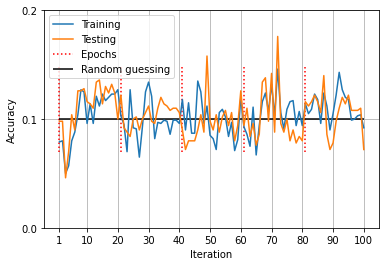

In [37]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)